<a href="https://colab.research.google.com/github/synchronizeteam/channa_classification/blob/model_aldy/Channa_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import io
import gdown

from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from google.colab import files
from PIL import Image
import os

%matplotlib inline

torch.manual_seed(123)

In [ ]:
#Pastiin pake GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Definisi Kelas
class_names = ['andrao', 'asiatica', 'auranti', 'barca', 'maru', 'stewartii']

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])

In [ ]:
# Set input and output directories
# input_dir = '/content/drive/MyDrive/datasheet'
# output_dir = '/content/drive/MyDrive/datasheet_jpg'

In [ ]:
# # Loop through all image files in the input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Open the image file
#         img_path = os.path.join(input_dir, filename)
#         img = Image.open(img_path)

#         # Create output filename by replacing extension with .jpg
#         output_filename = os.path.splitext(filename)[0] + '.jpg'
#         output_path = os.path.join(output_dir, output_filename)

#         # Convert the image to JPEG format and save to output file
#         img.save(output_path, 'JPEG')

In [ ]:
# Download Datasheet
url = "https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6"
output = "datasheet.zip"

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1P1LRTg_UZi8Ns56F8pkB8B0hAEiIwYK6
To: /content/datasheet.zip
100%|██████████| 969M/969M [00:03<00:00, 246MB/s]


'datasheet.zip'

In [ ]:
#ekstrak file
!unzip "/content/datasheet.zip" -d "/content/"

Archive:  /content/datasheet.zip
replace /content/datasheet/barca/barca_75.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
#apply pada dataset yg dipakai
dataset = torchvision.datasets.ImageFolder('/content/datasheet', transform=transform)

In [ ]:
#split data train dan val, buat loader
class_indices = {}
for i, (image, label) in enumerate(dataset):
    if label not in class_indices:
        class_indices[label] = []
    class_indices[label].append(i)

train_indices = []
val_indices = []

for label in class_indices.keys():
    indices = class_indices[label]
    num_samples = len(indices)
    split = int(0.8 * num_samples)  #80:20 setiap kelas
    train_indices.extend(indices[:split])
    val_indices.extend(indices[split:])

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

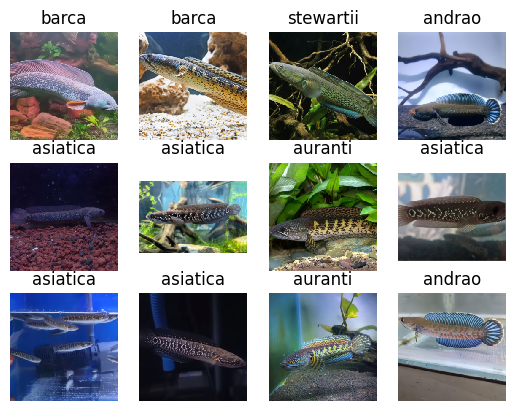

In [ ]:
#cek gambar data
images, labels = next(iter(train_loader))

fig = plt.figure()
#plot gambar
for i in range(12):
    img = np.transpose(images[i-1], (1, 2, 0))
    # denormalized_img = (img * 0.5) + 0.5
    plt.subplot(3,4,i+1)
    plt.imshow(img, interpolation='none')
    plt.title(class_names[labels[i-1]])
    plt.axis('off')

plt.show()

In [ ]:
#pakai model MobileNet yg diatur jumlah layernya
class AlexNet(nn.Module):
    def __init__(self, num_classes=6):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),  # Add dropout layer with p=0.5
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet().to(device)

In [ ]:
#atur loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
#define jumlah epoch, sama variabel kosongan untuk diisi nilai
n_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_correct = 0
    val_loss = 0.0
    val_correct = 0
    
    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) #pake CUDA
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device) #pake CUDA
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Print the results for this epoch
    print("Epoch {}: loss {:.4f}, accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}".format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))

Epoch 1: loss 1.7942, accuracy 15.4167, val_loss 1.7892, val_accuracy 16.6667
Epoch 2: loss 1.7748, accuracy 20.6250, val_loss 1.7800, val_accuracy 16.6667
Epoch 3: loss 1.7273, accuracy 21.4583, val_loss 1.6741, val_accuracy 29.1667
Epoch 4: loss 1.6354, accuracy 32.5000, val_loss 1.6278, val_accuracy 35.8333
Epoch 5: loss 1.6106, accuracy 35.2083, val_loss 1.5976, val_accuracy 30.0000
Epoch 6: loss 1.5176, accuracy 38.9583, val_loss 1.5523, val_accuracy 34.1667
Epoch 7: loss 1.4939, accuracy 40.4167, val_loss 1.4684, val_accuracy 40.8333
Epoch 8: loss 1.3740, accuracy 46.4583, val_loss 1.4608, val_accuracy 44.1667
Epoch 9: loss 1.3224, accuracy 50.4167, val_loss 1.3775, val_accuracy 47.5000
Epoch 10: loss 1.2484, accuracy 52.9167, val_loss 1.3154, val_accuracy 50.8333
Epoch 11: loss 1.1091, accuracy 57.5000, val_loss 1.2532, val_accuracy 49.1667
Epoch 12: loss 1.0561, accuracy 60.0000, val_loss 1.2229, val_accuracy 51.6667
Epoch 13: loss 1.0035, accuracy 60.8333, val_loss 1.1627, val

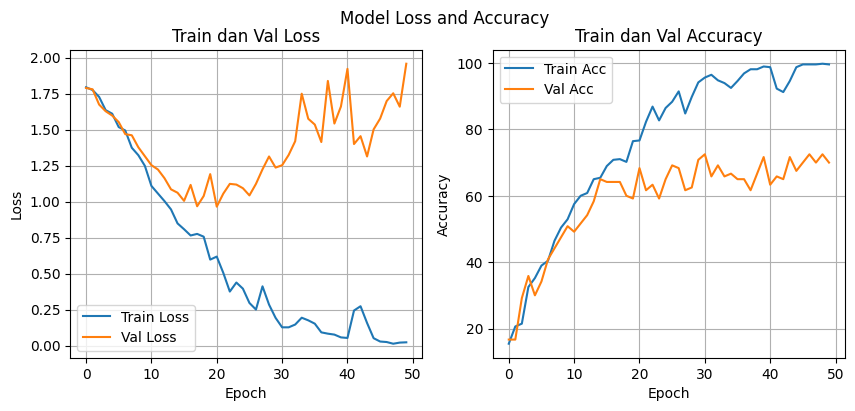

In [ ]:
#bikin plot dari hasil training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train dan Val Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc')
ax2.plot(val_accuracies, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train dan Val Accuracy')
ax2.legend()
ax2.grid(True)

fig.suptitle('Model Loss and Accuracy')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#simpen model
torch.save(model.state_dict(), '/content/drive/MyDrive/Ikan_Channa_VGG16_v4')

In [ ]:
#load model
model.load_state_dict(torch.load('/content/drive/MyDrive/Ikan_Channa_VGG16_v4'))

<All keys matched successfully>

Saving test_7.jpg to test_7.jpg
test_7.jpg
barca


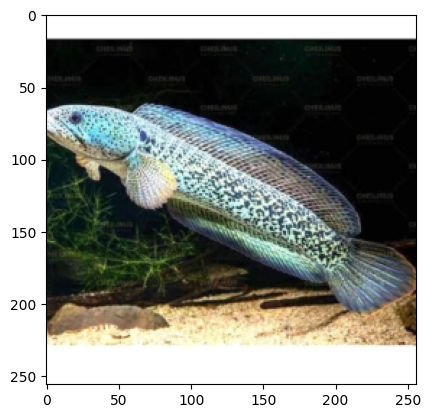

In [ ]:
#pengujian model yg dilatih
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = torchvision.transforms.functional.resize(
        torchvision.transforms.functional.to_pil_image(
            np.array(Image.open(io.BytesIO(uploaded[fn])))
        ),
        (256, 256)
    )

    imgplot = plt.imshow(img)
    x = torchvision.transforms.functional.to_tensor(img)
    x = x.unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
    
    _, preds = torch.max(outputs, 1)
    
    print(fn)
    if preds.item() == 0:
        print('andrao')
    elif preds.item() == 1:
        print('asiatica')
    elif preds.item() == 2:
        print('auranti')
    elif preds.item() == 3:
        print('barca')          
    elif preds.item() == 4:
        print('maru')
    elif preds.item() == 5:
        print('stewartii')
    else:
        print('not detected')
